<a href="https://colab.research.google.com/github/ChristopherLiew/Recession-Forecasting-US/blob/master/EDA_%26_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
!pip install plotly -U # Update Plotly for additonal tools -> Restart runtime after update
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
import glob
import os
from datetime import datetime
from functools import reduce
from google.colab import drive 
drive.mount('/content/gdrive')

     |████████████████████████████████| 13.2MB 269kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


## Finalised Dataset
Our finalised dataset comprises of 650 observations and 12 features.

In [ ]:
# Pull dataset
rec_data = pd.read_csv("/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/final_data.csv")
rec_data

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,DEBT_HH,SP500,INDPRO,TCU,UNRATE,Is_Recession
0,1966-01-01,62529,4.42,4.59,4.88,4.86,4.61,0.000000,40.33999,0.000,92.88,34.1729,0.0000,4.0,0
1,1966-02-01,62796,4.60,4.65,4.94,4.98,4.83,0.628931,40.33999,0.000,91.22,34.3945,0.0000,3.8,0
2,1966-03-01,63192,4.66,4.59,4.97,4.92,4.87,0.312500,40.33999,0.000,89.23,34.8652,0.0000,3.8,0
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,0.000,91.06,34.9206,0.0000,3.8,0
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,0.000,86.13,35.2529,0.0000,3.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2019-10-01,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,75.462,3037.56,109.0270,76.9891,3.6,0
646,2019-11-01,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,75.462,3140.98,110.0388,77.5723,3.6,0
647,2019-12-01,151919,1.55,1.54,1.55,1.68,1.86,-0.090977,106.68579,75.462,3230.78,109.6527,77.1697,3.6,0
648,2020-01-01,152234,1.55,1.52,1.53,1.56,1.76,0.387977,107.71144,76.450,3225.52,109.1845,76.8754,3.5,0


#### Get all recession periods

In [ ]:
v = (rec_data['Is_Recession'] != rec_data['Is_Recession'].shift()).cumsum()
u = rec_data.groupby(v)['Is_Recession'].agg(['all', 'count'])
m = u['all'] & u['count'].ge(3)

In [ ]:
recession_periods_idx = rec_data.groupby(v).apply(lambda x: (x.index[0], x.index[-1]))[m]
recession_periods = [(rec_data.iloc[i, 0], rec_data.iloc[j, 0]) for i, j in recession_periods_idx]
recession_periods

[('1969-12-01', '1970-11-01'),
 ('1973-11-01', '1975-03-01'),
 ('1980-01-01', '1980-07-01'),
 ('1981-07-01', '1982-11-01'),
 ('1990-07-01', '1991-03-01'),
 ('2001-03-01', '2001-11-01'),
 ('2007-12-01', '2009-06-01')]

## Handling Missing Data
No missing data found sans the CPI hitting 0 in certain instances and our limited historical data for S&P 500 and Household Debt.



In [ ]:
rec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               650 non-null    object 
 1   PAYEMS             650 non-null    int64  
 2   FEDFUNDS           650 non-null    float64
 3   3MTB_SECONDARYMKT  650 non-null    float64
 4   GS1                650 non-null    float64
 5   GS5                650 non-null    float64
 6   GS10               650 non-null    float64
 7   CPI                650 non-null    float64
 8   DEBT_PUB           650 non-null    float64
 9   DEBT_HH            650 non-null    float64
 10  SP500              650 non-null    float64
 11  INDPRO             650 non-null    float64
 12  TCU                650 non-null    float64
 13  UNRATE             650 non-null    float64
 14  Is_Recession       650 non-null    int64  
dtypes: float64(12), int64(2), object(1)
memory usage: 76.3+ KB


## Feature Engineering

### Interest rate spread: 10 year - 3 month (See Kauppi)
Detects yield curve inversions which precede major recessions such as the GFC of 2008. However, false alarms do happen as the yield curve inverted in 2019 but a recessions was not baked in until COVID-19 happened.

In [ ]:
int_rate_spread = rec_data['GS10'] - rec_data['3MTB_SECONDARYMKT']
rec_data['10Y3MTH_SPREAD'] = int_rate_spread

In [ ]:
fig = px.box(rec_data, x="Is_Recession", y="10Y3MTH_SPREAD", 
             points = 'all',
             color="Is_Recession",
             notched=True, # used notched shape
             title="Boxplot of Interest Rate Spread"
            )
fig.show()

Interest rate spread seems to dip more deeply into negative region during a recession. However, we also see a number of negative outliers with larger negative values when there is no recession (i.e. during the Expansion period). This might be due to a yield curve inversion occurring in the leading up to an actual recession.

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

As observed, the spread always dips into negative territory preceding a recession. Even in 2019, we observe a yield curve inversion just before 2020 between the months of May till October, foreshadowing a possible recession in late 2019 to early 2020. Of which, was triggered due to COVID-19.

### Capturing momentum
#### Rolling Window (3 month)
We use a 3 month rolling window to capture condensed information on past values of a indicator variable.
##### 1) Non farm payrolls

In [ ]:
rec_data['PAYEMS_ROLMEAN3'] = rec_data['PAYEMS'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'PAYEMS_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to lag the recession rather than lead the recession. May not be super useful.

##### 2) Fed Funds Rate

In [ ]:
rec_data['FEDFUNDS_ROLMEAN3'] = rec_data['FEDFUNDS'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'FEDFUNDS_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to hit a peak right before the onset of a recession.

##### 3) 10 year - 3 month interest rate spread

In [ ]:
rec_data['10Y3MTH_SPREAD_ROLMEAN3'] = rec_data['10Y3MTH_SPREAD'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Like its unadultered interest rate spread indicator, it dips below the 0 mark prior to a recession but the values are averaged out and thus less pronounced. How would a less pronounced yield curve affect predictive accuracy.

##### 4) CPI

In [ ]:
rec_data['CPI_ROLMEAN3'] = rec_data['CPI'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'CPI_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Appears to consistently be on the rise before a recession except for the 1981 recession.

##### 5) Public Debt

In [ ]:
rec_data['DEBT_PUB_ROLMEAN3'] = rec_data['DEBT_PUB'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_PUB_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

General rising trend, but could be due to exogenous factors apart from economic climate. Appears to and naturally rises during a recession, but no clear and consistent behvaiour prior to a recession.

##### 6) Household Debt

In [ ]:
rec_data['DEBT_HH_ROLMEAN3'] = rec_data['DEBT_HH'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_HH_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
# Only tracked prior to the GFC circa 2007-8
start, end = recession_periods[-1]
fig.add_vrect(x0=start, x1=end, 
              annotation_text="recession", annotation_position="top left",
              fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Too small a sample size to determine utility, but naturally rose due to households accruing bad debt (subprime mortgage crisis).

##### 7) S&P 500 Index

In [ ]:
rec_data['SP500_ROLMEAN3'] = rec_data['SP500'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'SP500_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Observably hits a peak right before a recession. However, as observed the during COVID-19 recession, the stock market was floated up by 'over-valued' tech stocks.

##### 8) Industrial Production

In [ ]:
rec_data['INDPRO_ROLMEAN3'] = rec_data['INDPRO'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'INDPRO_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally precedes the recession (E.g. the GFC and early 2000s recession). In other cases, the peak seems to come early into the recession period.

##### 9) Capacity Utilisation

In [ ]:
rec_data['TCU_ROLMEAN3'] = rec_data['TCU'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'TCU_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally precedes the recession (E.g. the GFC and early 2000s recession). In other cases, the peak seems to come early into the recession period.

##### 10) Unemployment Rate

In [ ]:
rec_data['UNRATE_ROLMEAN3'] = rec_data['UNRATE'].rolling(window=3).mean()

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'UNRATE_ROLMEAN3')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Unemployment trough comes before the recession, however, there may be multiple false positives, as it could hit a local minimum and recover before dropping again. However, it seems reliable.

#### Percentage Change (3 month)
Nothing more than 3 months so we do not lose too many observations.
##### 1) Non farm payrolls

In [ ]:
rec_data['PAYEMS_3MTHCHANGE'] = rec_data['PAYEMS'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'PAYEMS_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 2) Fed Funds Rate

In [ ]:
rec_data['FEDFUNDS_3MTHCHANGE'] = rec_data['FEDFUNDS'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'FEDFUNDS_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 3) Interest rate spread

In [ ]:
rec_data['10Y3MTH_SPREAD_3MTHCHANGE'] = rec_data['10Y3MTH_SPREAD'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = '10Y3MTH_SPREAD_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 4) Inflation

In [ ]:
rec_data['CPI_3MTHCHANGE'] = rec_data['CPI'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'CPI_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 5) Public debt

In [ ]:
rec_data['DEBT_PUB_3MTHCHANGE'] = rec_data['DEBT_PUB'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_PUB_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 6) Household Debt

In [ ]:
rec_data['DEBT_HH_3MTHCHANGE'] = rec_data['DEBT_HH'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'DEBT_HH_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 7) S&P 500

In [ ]:
rec_data['SP500_3MTHCHANGE'] = rec_data['SP500'].pct_change(periods = 3)
fig = px.line(rec_data, x = 'DATE', y = 'SP500_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

##### 8) Industrial Production

In [ ]:
rec_data['INDPRO_3MTHCHANGE'] = rec_data['INDPRO'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'INDPRO_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Occasionally dips into negative region preceding a recession and bottoms out during a recession.

##### 9) Capacity Utilisation

In [ ]:
rec_data['TCU_3MTHCHANGE'] = rec_data['TCU'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'TCU_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Consistently dips into negative territory preceding a recession

##### 10) Unemployment Rate

In [ ]:
rec_data['UNRATE_3MTHCHANGE'] = rec_data['UNRATE'].pct_change(periods = 3)

In [ ]:
fig = px.line(rec_data, x = 'DATE', y = 'UNRATE_3MTHCHANGE')
fig.add_hline(y = 0.0)
# Add in recession periods
for start, end in recession_periods:
    fig.add_vrect(x0=start, x1=end, 
                annotation_text="recession", annotation_position="top left",
                fillcolor="red", opacity=0.25, line_width=1)
fig.show()

Erratic but trends upwards right before a recession, but may be too noisy a variable to add sufficient predictive power.

#### Removing less promising variables


*   PAYEMS_ROLMEAN3
*   10Y3MTH_SPREAD_ROLMEAN3
*   CPI_ROLMEAN3
*   DEBT_PUB_ROLMEAN3
*   DEBT_HH_ROLMEAN3
*   SP500_ROLMEAN3
*   TCU_ROLMEAN3
*   FEDFUNDS_3MTHCHANGE
*   CPI_3MTHCHANGE
*   DEBT_PUB_3MTHCHANGE
*   DEBT_HH_3MTHCHANGE
*   UNRATE_3MTHCHANGE
*   SP500_3MTHCHANGE
*   TCU_3MTHCHANGE



In [ ]:
rec_data_final = rec_data.drop(columns=['DEBT_HH',
                                        'TCU',
                                        'PAYEMS_ROLMEAN3',
                                        '10Y3MTH_SPREAD_ROLMEAN3',
                                        'CPI_ROLMEAN3',
                                        'DEBT_PUB_ROLMEAN3',
                                        'DEBT_HH_ROLMEAN3',
                                        'SP500_ROLMEAN3',
                                        'TCU_ROLMEAN3',
                                        'FEDFUNDS_3MTHCHANGE',
                                        'CPI_3MTHCHANGE',
                                        'DEBT_PUB_3MTHCHANGE',
                                        'DEBT_HH_3MTHCHANGE',
                                        'UNRATE_3MTHCHANGE',
                                        'SP500_3MTHCHANGE',
                                        'TCU_3MTHCHANGE'])

In [ ]:
# Clean data of infs and missing values
rec_data_final.replace({'' : np.NaN, np.inf: np.NaN}, inplace=True)
rec_data_final.dropna(inplace=True)

In [ ]:
# Write data
rec_data_final.to_csv('/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/Model Data/recession_data_final_no_lags.csv', index=False)

In [ ]:
rec_data_final

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,91.06,34.9206,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,86.13,35.2529,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957
5,1966-06-01,64111,5.17,4.50,4.97,4.97,4.81,0.309598,39.26763,84.74,35.4191,3.8,0,0.31,4.913333,35.197533,3.833333,0.014543,0.107143,0.015887
6,1966-07-01,64301,5.30,4.80,5.17,5.17,5.02,0.308642,39.62091,83.60,35.6129,3.8,0,0.22,5.123333,35.428300,3.833333,0.013620,0.692308,0.019825
7,1966-08-01,64507,5.53,4.96,5.54,5.50,5.22,0.615385,39.62091,77.10,35.6406,3.8,0,0.26,5.333333,35.557533,3.800000,0.012478,0.857143,0.010998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2019-10-01,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,3037.56,109.0270,3.6,0,0.06,2.000000,109.451267,3.600000,0.004049,-2.500000,-0.000534
646,2019-11-01,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,3140.98,110.0388,3.6,0,0.27,1.806667,109.512767,3.566667,0.004302,-1.843750,0.001679
647,2019-12-01,151919,1.55,1.54,1.55,1.68,1.86,-0.090977,106.68579,3230.78,109.6527,3.6,0,0.32,1.643333,109.572833,3.600000,0.003899,-2.684211,0.001646
648,2020-01-01,152234,1.55,1.52,1.53,1.56,1.76,0.387977,107.71144,3225.52,109.1845,3.5,0,0.24,1.550000,109.625333,3.566667,0.004686,3.000000,0.001445


In [ ]:
index = rec_data_final[rec_data_final['DATE'] == '2000-01-01'].index.values
index

array([408])

## Final Dataset

In [ ]:
rec_data_final.drop(rec_data_final.tail(2).index,inplace=True)
rec_data_final

,DATE,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,Is_Recession,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
3,1966-04-01,63437,4.67,4.62,4.90,4.83,4.75,0.623053,39.26763,91.06,34.9206,3.8,0,0.13,4.643333,34.726767,3.800000,0.014521,5.500000,0.021880
4,1966-05-01,63712,4.90,4.64,4.93,4.89,4.78,0.000000,39.26763,86.13,35.2529,3.9,0,0.14,4.743333,35.012900,3.833333,0.014587,-0.222222,0.024957
5,1966-06-01,64111,5.17,4.50,4.97,4.97,4.81,0.309598,39.26763,84.74,35.4191,3.8,0,0.31,4.913333,35.197533,3.833333,0.014543,0.107143,0.015887
6,1966-07-01,64301,5.30,4.80,5.17,5.17,5.02,0.308642,39.62091,83.60,35.6129,3.8,0,0.22,5.123333,35.428300,3.833333,0.013620,0.692308,0.019825
7,1966-08-01,64507,5.53,4.96,5.54,5.50,5.22,0.615385,39.62091,77.10,35.6406,3.8,0,0.26,5.333333,35.557533,3.800000,0.012478,0.857143,0.010998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2019-08-01,151108,2.13,1.95,1.77,1.49,1.63,-0.005067,105.47381,2926.46,109.8543,3.7,0,-0.32,2.303333,109.405633,3.633333,0.003740,-7.400000,0.005749
644,2019-09-01,151329,2.04,1.89,1.80,1.57,1.70,0.078345,105.47381,2976.74,109.4725,3.5,0,-0.19,2.190000,109.470667,3.600000,0.004041,0.900000,0.001785
645,2019-10-01,151524,1.83,1.65,1.61,1.53,1.71,0.228619,106.68579,3037.56,109.0270,3.6,0,0.06,2.000000,109.451267,3.600000,0.004049,-2.500000,-0.000534
646,2019-11-01,151758,1.55,1.54,1.57,1.64,1.81,-0.053624,106.68579,3140.98,110.0388,3.6,0,0.27,1.806667,109.512767,3.566667,0.004302,-1.843750,0.001679


In [ ]:
y = rec_data_final['Is_Recession']
date = rec_data_final['DATE']
date

3      1966-04-01
4      1966-05-01
5      1966-06-01
6      1966-07-01
7      1966-08-01
          ...    
643    2019-08-01
644    2019-09-01
645    2019-10-01
646    2019-11-01
647    2019-12-01
Name: DATE, Length: 645, dtype: object

## EDA & Further Preprocessing
In order to prevent data leakage we should only perform EDA and further preprocessing operations (E.g. Normalisation or Standardisation) on our predefined test set (i.e. our test set before recursively expanding it during cross validation)


### 1) Class Imbalance

In [ ]:
print("Class ratio of Recession against Expansion: %.2f" % (rec_data_final.Is_Recession.sum() / len(rec_data_final.Is_Recession)))

Class ratio of Recession against Expansion: 0.14


In [ ]:
px.histogram(rec_data_final, x = 'Is_Recession',
             title='Class frequencies (Expansions Vs. Recessions)',
             color='Is_Recession',
             opacity=0.8)

### 2) Pairplot of all features

In [ ]:
# Change all the imputed zeros (SP500, DEBT_HH & TCU) into NAs ?
# Drop infs from pct_change in TCU since X/0 = infs
# rec_data_final_clean = rec_data_final.replace([np.inf, -np.inf], np.nan) # Losing 14 observations here hmm...

In [ ]:
# WARNING: Very expensive to run; Refer to saved image or run only when certain
# pairplot = sns.pairplot(rec_data_final_clean.drop(columns=['DATE']), hue = 'Is_Recession', dropna = True)

In [ ]:
# Save the pair plot
# pairplot.savefig('/content/gdrive/My Drive/EC4308/Project/Code & Data/Data/pairplot.png')

### 3) Overall Distribution of Values across all Features (Boxplots grouped by Recession Indicator)

In [ ]:
# Gotta figure this out
# px.box(rec_data_final.drop(columns=['DATE']).melt(), y='value', facet_col='variable').update_yaxes(matches=None)

### 4) Heatmap of All Correlated Features
Yee Hsien you might want to drop the original features here and keep the momentum ones since a Probit or Logit model would probably not play well with high collinearity.

In [ ]:
# plt.figure(figsize=(30, 30), dpi = 80)
# sns.heatmap(rec_data_final_EDA.corr(), cmap='jet', annot=True);

### 5) Partial autocorrelation for each baseline (non feature-engineered) feature

### 0) Recession Indicator (Autoregressive component [details here](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8#:~:text=ACF%20is%20an%20(c%20o,series%20with%20its%20lagged%20values%20.&text=ACF%20considers%20all%20these%20components,a%20partial%20auto%2Dcorrelation%20function.com)) ) 

We would prefer deferring to PACF here to isolate only the specific lags which have strong predictive power on our current value.

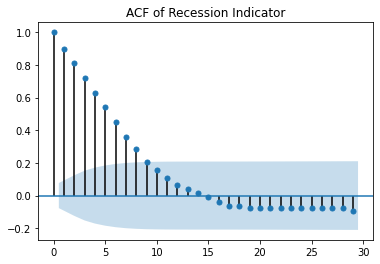

In [ ]:
# ACF for the lols
plot_acf(rec_data.Is_Recession, title = 'ACF of Recession Indicator');

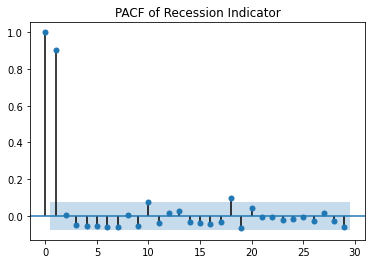

In [ ]:
# PACF for the lols
plot_pacf(rec_data.Is_Recession, title = 'PACF of Recession Indicator');

### 1) Fed Funds Rate

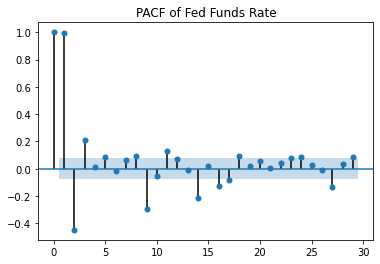

In [ ]:
# PACF 
plot_pacf(rec_data.FEDFUNDS, title = 'PACF of Fed Funds Rate');

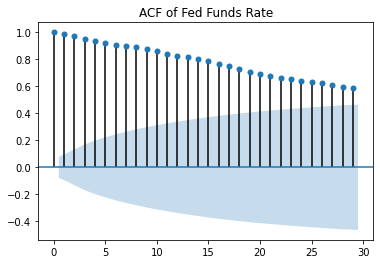

In [ ]:
plot_acf(rec_data.FEDFUNDS, title = 'ACF of Fed Funds Rate');

### 2) Interest Rate Spread

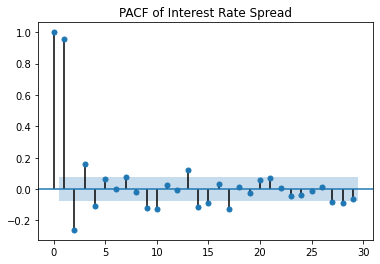

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['10Y3MTH_SPREAD']], title = 'PACF of Interest Rate Spread');

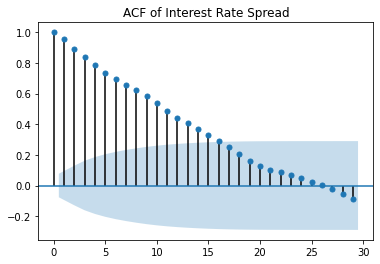

In [ ]:
# ACF
plot_acf(rec_data.loc[:, ['10Y3MTH_SPREAD']], title = 'ACF of Interest Rate Spread');

### 3) Inflation

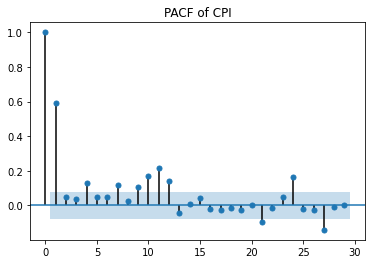

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['CPI']], title = 'PACF of CPI');

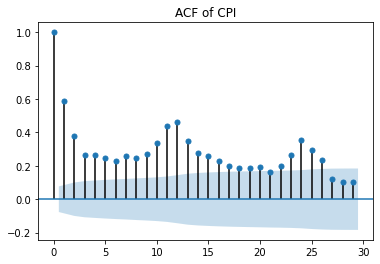

In [ ]:
plot_acf(rec_data.loc[:, ['CPI']], title = 'ACF of CPI');

### 4) Public Debt

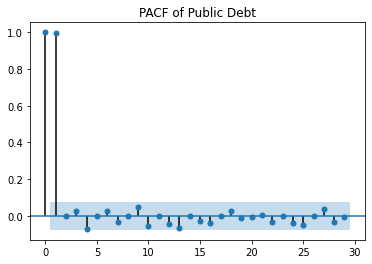

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['DEBT_PUB']], title = 'PACF of Public Debt');

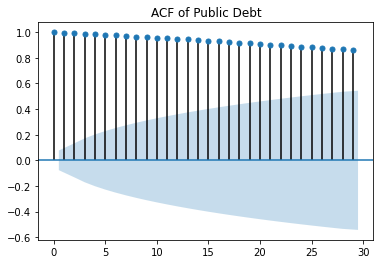

In [ ]:
plot_acf(rec_data.loc[:, ['DEBT_PUB']], title = 'ACF of Public Debt');

### 5) Household Debt (Dropped)

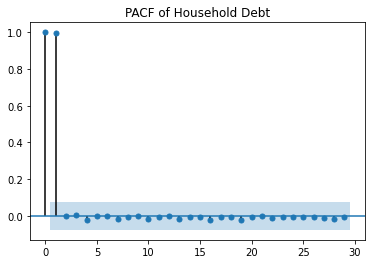

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['DEBT_HH']], title = 'PACF of Household Debt');

### 6) S&P 500

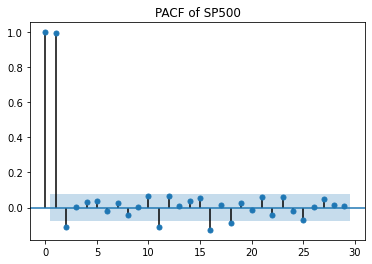

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['SP500']], title = 'PACF of SP500');

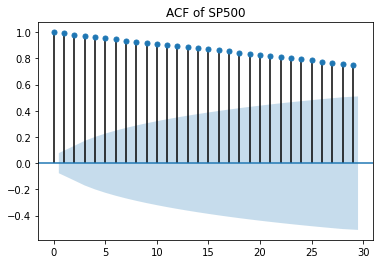

In [ ]:
plot_acf(rec_data.loc[:, ['SP500']], title = 'ACF of SP500');

### 7) Industrial Production

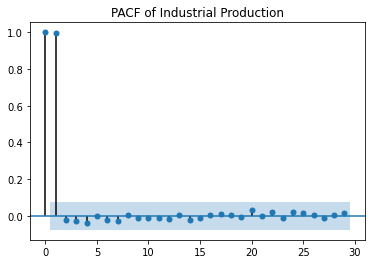

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['INDPRO']], title = 'PACF of Industrial Production');

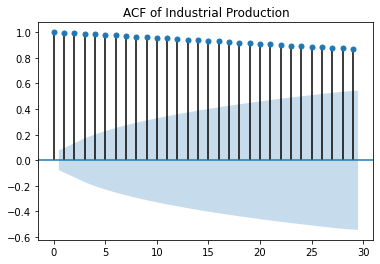

In [ ]:
plot_acf(rec_data.loc[:, ['INDPRO']], title = 'ACF of Industrial Production');

### 8) Capacity Utilisation (Dropped)

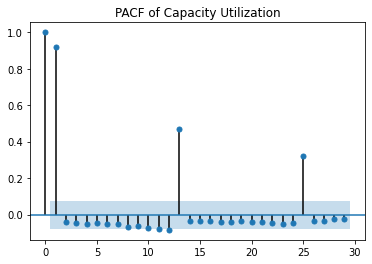

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['TCU']], title = 'PACF of Capacity Utilization');

### 9) Unemployment Rate

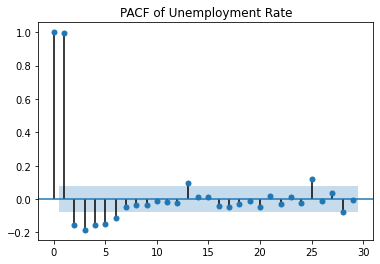

In [ ]:
# PACF 
plot_pacf(rec_data.loc[:, ['UNRATE']], title = 'PACF of Unemployment Rate');

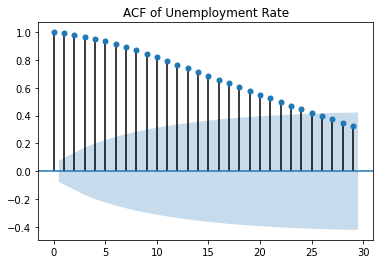

In [ ]:
plot_acf(rec_data.loc[:, ['UNRATE']], title = 'ACF of Unemployment Rate');

For many of our variables PACF is significant up to 2nd to 4th lag, though there are some variations throughout. For instance, Unemployment Rate has a significant PACF coefficient up till about lag 25, however, we would lose to many observations by using p = 25. Thus, to create a rangle of suitable lags to empirically develop our initial lagged datasets with we will define our lagged value range as between 1 ~ 6, since a number of features have significant PACF coefficients within this range of values.

## Stationarity Test and Differeing

In [ ]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as mp

In [ ]:
rec_data_final.columns

Index(['DATE', 'PAYEMS', 'FEDFUNDS', '3MTB_SECONDARYMKT', 'GS1', 'GS5', 'GS10',
       'CPI', 'DEBT_PUB', 'SP500', 'INDPRO', 'UNRATE', 'Is_Recession',
       '10Y3MTH_SPREAD', 'FEDFUNDS_ROLMEAN3', 'INDPRO_ROLMEAN3',
       'UNRATE_ROLMEAN3', 'PAYEMS_3MTHCHANGE', '10Y3MTH_SPREAD_3MTHCHANGE',
       'INDPRO_3MTHCHANGE'],
      dtype='object')

In [ ]:
rec_data_final.drop(['DATE', 'Is_Recession'], axis = 1, inplace = True)

In [ ]:
rec_data_final.columns

Index(['PAYEMS', 'FEDFUNDS', '3MTB_SECONDARYMKT', 'GS1', 'GS5', 'GS10', 'CPI',
       'DEBT_PUB', 'SP500', 'INDPRO', 'UNRATE', '10Y3MTH_SPREAD',
       'FEDFUNDS_ROLMEAN3', 'INDPRO_ROLMEAN3', 'UNRATE_ROLMEAN3',
       'PAYEMS_3MTHCHANGE', '10Y3MTH_SPREAD_3MTHCHANGE', 'INDPRO_3MTHCHANGE'],
      dtype='object')

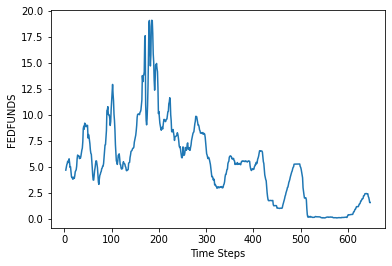

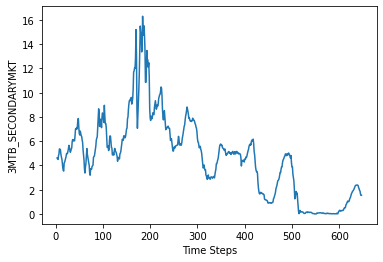

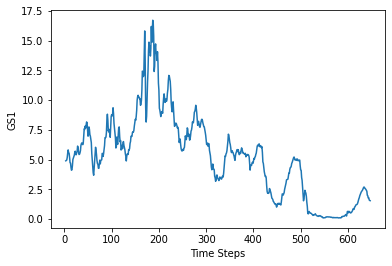

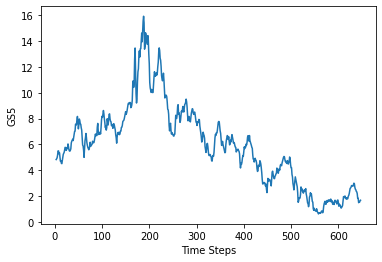

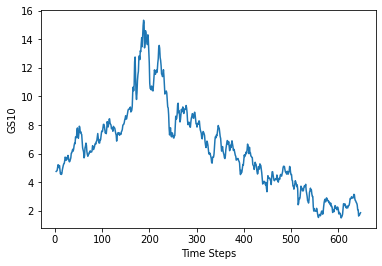

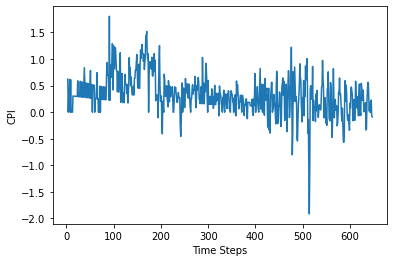

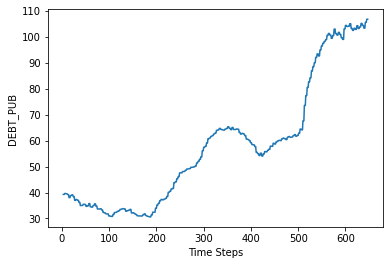

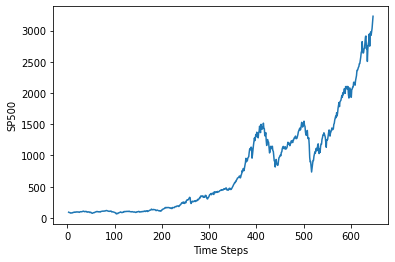

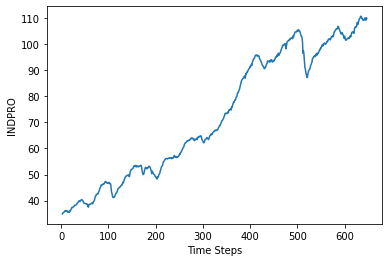

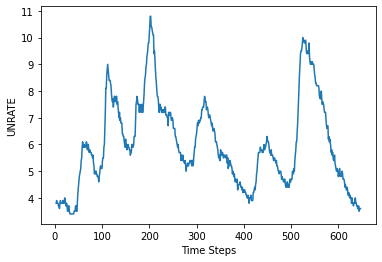

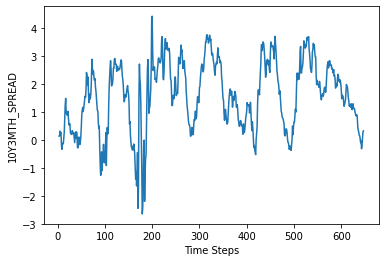

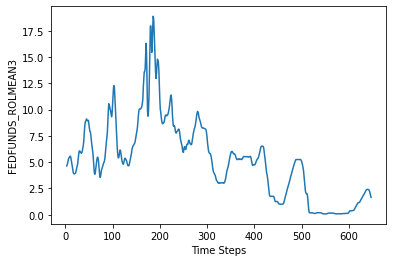

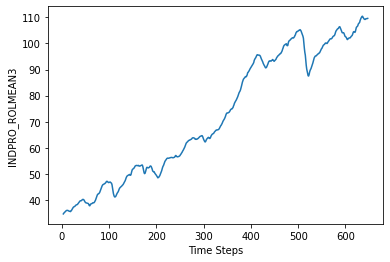

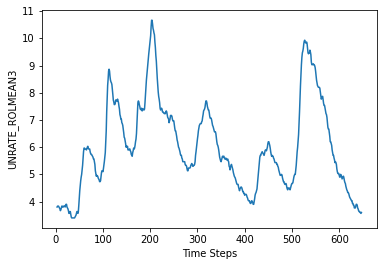

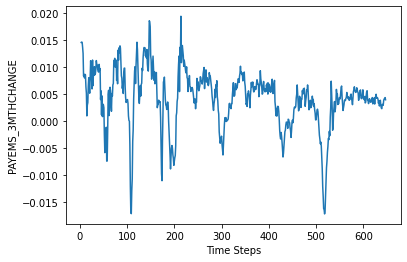

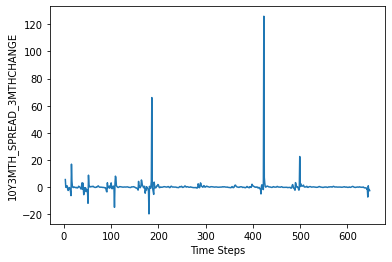

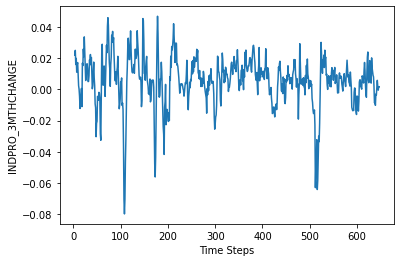

In [ ]:
col = ['PAYEMS', 'FEDFUNDS', '3MTB_SECONDARYMKT', 'GS1', 'GS5', 'GS10', 'CPI',
       'DEBT_PUB', 'SP500', 'INDPRO', 'UNRATE', '10Y3MTH_SPREAD',
       'FEDFUNDS_ROLMEAN3', 'INDPRO_ROLMEAN3', 'UNRATE_ROLMEAN3',
       'PAYEMS_3MTHCHANGE', '10Y3MTH_SPREAD_3MTHCHANGE', 'INDPRO_3MTHCHANGE']

for i in col[1:]:
    plt.figure()
    plt.plot(rec_data_final[i])
    plt.ylabel(i)
    plt.xlabel('Time Steps')
    plt.show()

In [ ]:
for i in col[1:]:
    print(i)
    X_temp = rec_data_final[i].values
    result = adfuller(X_temp)

    print('ADF Statistics: %f' %result[0])
    print('p-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key , value))
    
    if result[0] < result[4]["5%"]:
        print("reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 = Time Series is Non-Stationary")
    
    print()

FEDFUNDS
ADF Statistics: -2.521764
p-value: 0.110268
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

3MTB_SECONDARYMKT
ADF Statistics: -1.884712
p-value: 0.339287
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

GS1
ADF Statistics: -1.583366
p-value: 0.491944
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

GS5
ADF Statistics: -0.992566
p-value: 0.755966
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

GS10
ADF Statistics: -0.953651
p-value: 0.769792
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

CPI
ADF Statistics: -2.617562
p-value: 0.089422
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject H0 = Time Series is Non-Stationary

DEBT_PUB
ADF Statistics: -0.084889
p-value: 0.9509

In [ ]:
rec_data_final_diff = rec_data_final.diff()

rec_data_final_diff.dropna()

,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
4,275.0,0.23,0.02,0.03,0.06,0.03,-0.623053,0.00000,-4.93,0.3323,0.1,0.01,0.100000,0.286133,0.033333,0.000066,-5.722222,0.003078
5,399.0,0.27,-0.14,0.04,0.08,0.03,0.309598,0.00000,-1.39,0.1662,-0.1,0.17,0.170000,0.184633,0.000000,-0.000044,0.329365,-0.009071
6,190.0,0.13,0.30,0.20,0.20,0.21,-0.000956,0.35328,-1.14,0.1938,0.0,-0.09,0.210000,0.230767,0.000000,-0.000923,0.585165,0.003938
7,206.0,0.23,0.16,0.37,0.33,0.20,0.306743,0.00000,-6.50,0.0277,0.0,0.04,0.210000,0.129233,-0.033333,-0.001142,0.164835,-0.008827
8,136.0,-0.13,0.41,0.28,0.00,-0.04,-0.615385,0.00000,-0.54,0.3323,-0.1,-0.45,0.076667,0.184600,-0.033333,-0.004180,-2.470046,0.004638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,195.0,-0.27,-0.15,-0.19,-0.34,-0.43,-0.172161,0.00000,-53.92,0.7691,0.1,-0.28,-0.086667,0.209300,0.000000,0.000876,-6.133333,0.004864
644,221.0,-0.09,-0.06,0.03,0.08,0.07,0.083412,0.00000,50.28,-0.3818,-0.2,0.13,-0.113333,0.065033,-0.033333,0.000301,8.300000,-0.003963
645,195.0,-0.21,-0.24,-0.19,-0.04,0.01,0.150274,1.21198,60.82,-0.4455,0.1,0.25,-0.190000,-0.019400,0.000000,0.000008,-3.400000,-0.002319
646,234.0,-0.28,-0.11,-0.04,0.11,0.10,-0.282243,0.00000,103.42,1.0118,0.0,0.21,-0.193333,0.061500,-0.033333,0.000253,0.656250,0.002213


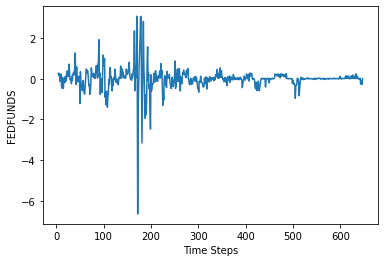

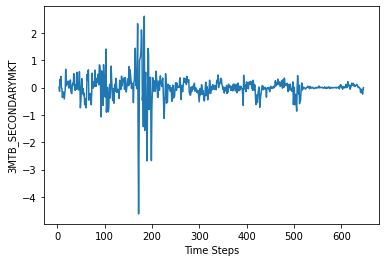

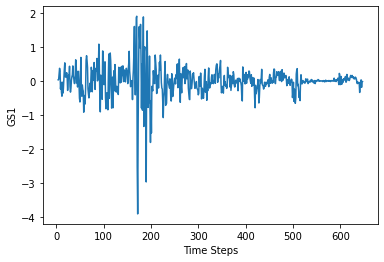

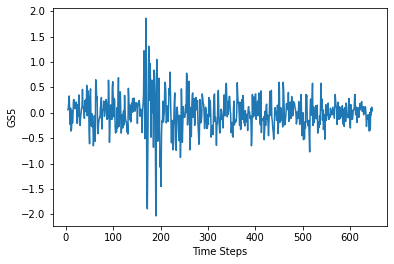

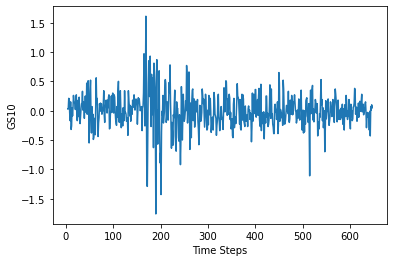

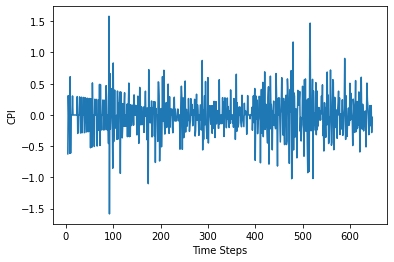

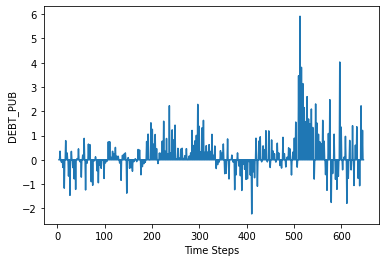

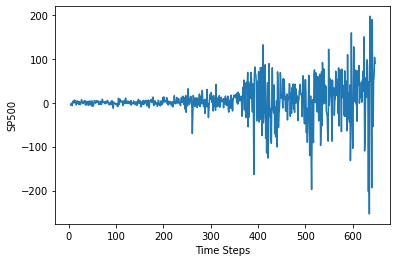

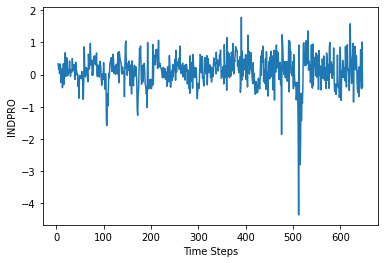

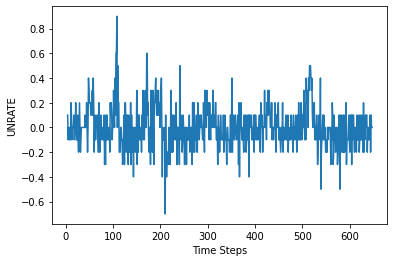

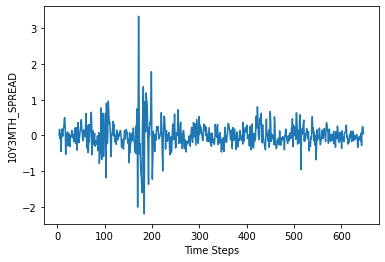

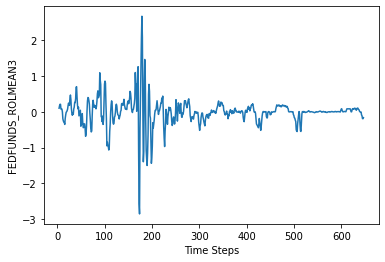

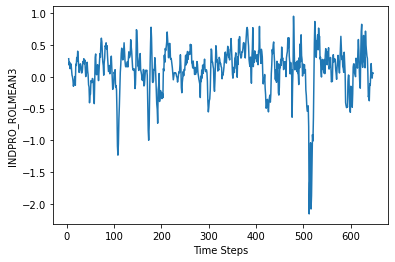

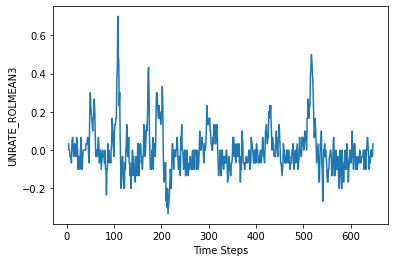

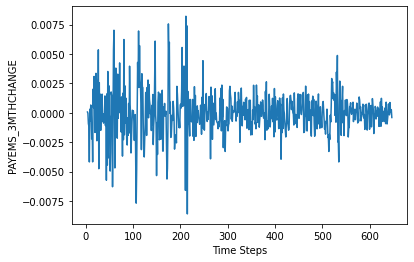

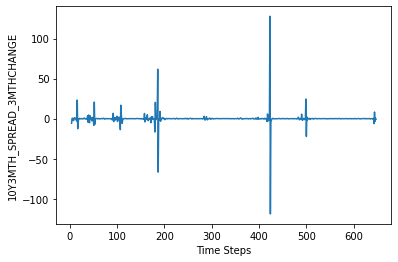

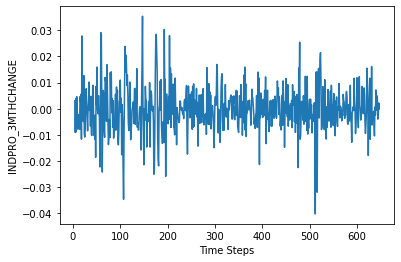

In [ ]:
col = ['PAYEMS', 'FEDFUNDS', '3MTB_SECONDARYMKT', 'GS1', 'GS5', 'GS10', 'CPI',
       'DEBT_PUB', 'SP500', 'INDPRO', 'UNRATE', '10Y3MTH_SPREAD',
       'FEDFUNDS_ROLMEAN3', 'INDPRO_ROLMEAN3', 'UNRATE_ROLMEAN3',
       'PAYEMS_3MTHCHANGE', '10Y3MTH_SPREAD_3MTHCHANGE', 'INDPRO_3MTHCHANGE']

for i in col[1:]:
    plt.figure()
    plt.plot(rec_data_final_diff[i])
    plt.ylabel(i)
    plt.xlabel('Time Steps')
    plt.show()

In [ ]:
for i in col[1:]:
    rec_data_final_diff[i].replace([np.inf, -np.inf], np.nan, inplace = True)           

In [ ]:
for i in col[1:]:
    print(i)
    X_diff_temp = rec_data_final_diff[i].values
    result = adfuller(X_diff_temp)

    print('ADF Statistics: %f' %result[0])
    print('p-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key , value))
    
    if result[0] < result[4]["5%"]:
        print("reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 = Time Series is Non-Stationary")
    
    print()

## Train Test Split

In [ ]:
rec_diff = pd.concat([date,y,rec_data_final_diff], axis = 1)
rec_diff.dropna()

,DATE,Is_Recession,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
4,1966-05-01,0,275.0,0.23,0.02,0.03,0.06,0.03,-0.623053,0.00000,-4.93,0.3323,0.1,0.01,0.100000,0.286133,0.033333,0.000066,-5.722222,0.003078
5,1966-06-01,0,399.0,0.27,-0.14,0.04,0.08,0.03,0.309598,0.00000,-1.39,0.1662,-0.1,0.17,0.170000,0.184633,0.000000,-0.000044,0.329365,-0.009071
6,1966-07-01,0,190.0,0.13,0.30,0.20,0.20,0.21,-0.000956,0.35328,-1.14,0.1938,0.0,-0.09,0.210000,0.230767,0.000000,-0.000923,0.585165,0.003938
7,1966-08-01,0,206.0,0.23,0.16,0.37,0.33,0.20,0.306743,0.00000,-6.50,0.0277,0.0,0.04,0.210000,0.129233,-0.033333,-0.001142,0.164835,-0.008827
8,1966-09-01,0,136.0,-0.13,0.41,0.28,0.00,-0.04,-0.615385,0.00000,-0.54,0.3323,-0.1,-0.45,0.076667,0.184600,-0.033333,-0.004180,-2.470046,0.004638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2019-08-01,0,195.0,-0.27,-0.15,-0.19,-0.34,-0.43,-0.172161,0.00000,-53.92,0.7691,0.1,-0.28,-0.086667,0.209300,0.000000,0.000876,-6.133333,0.004864
644,2019-09-01,0,221.0,-0.09,-0.06,0.03,0.08,0.07,0.083412,0.00000,50.28,-0.3818,-0.2,0.13,-0.113333,0.065033,-0.033333,0.000301,8.300000,-0.003963
645,2019-10-01,0,195.0,-0.21,-0.24,-0.19,-0.04,0.01,0.150274,1.21198,60.82,-0.4455,0.1,0.25,-0.190000,-0.019400,0.000000,0.000008,-3.400000,-0.002319
646,2019-11-01,0,234.0,-0.28,-0.11,-0.04,0.11,0.10,-0.282243,0.00000,103.42,1.0118,0.0,0.21,-0.193333,0.061500,-0.033333,0.000253,0.656250,0.002213


In [ ]:
index

array([408])

In [ ]:
rec_train = rec_diff.iloc[1:405,:]
rec_test = rec_diff.iloc[405:,:]

In [ ]:
rec_train.dropna()
rec_train

,DATE,Is_Recession,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
4,1966-05-01,0,275.0,0.23,0.02,0.03,0.06,0.03,-0.623053,0.00000,-4.93,0.3323,0.1,0.01,0.100000,0.286133,0.033333,0.000066,-5.722222,0.003078
5,1966-06-01,0,399.0,0.27,-0.14,0.04,0.08,0.03,0.309598,0.00000,-1.39,0.1662,-0.1,0.17,0.170000,0.184633,0.000000,-0.000044,0.329365,-0.009071
6,1966-07-01,0,190.0,0.13,0.30,0.20,0.20,0.21,-0.000956,0.35328,-1.14,0.1938,0.0,-0.09,0.210000,0.230767,0.000000,-0.000923,0.585165,0.003938
7,1966-08-01,0,206.0,0.23,0.16,0.37,0.33,0.20,0.306743,0.00000,-6.50,0.0277,0.0,0.04,0.210000,0.129233,-0.033333,-0.001142,0.164835,-0.008827
8,1966-09-01,0,136.0,-0.13,0.41,0.28,0.00,-0.04,-0.615385,0.00000,-0.54,0.3323,-0.1,-0.45,0.076667,0.184600,-0.033333,-0.004180,-2.470046,0.004638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,1999-08-01,0,155.0,0.08,0.17,0.17,0.16,0.15,-0.060890,0.00000,-8.31,0.3863,-0.1,-0.02,0.110000,0.270300,0.000000,-0.000445,-0.220182,-0.002688
404,1999-09-01,0,203.0,0.15,-0.04,0.05,-0.04,-0.02,0.238803,0.00000,-37.70,-0.3889,0.0,0.02,0.153333,0.191533,-0.033333,-0.000617,-0.240746,-0.002576
405,1999-10-01,0,405.0,-0.02,0.18,0.18,0.23,0.19,-0.300077,-0.07333,80.22,1.2239,-0.1,0.01,0.070000,0.407100,-0.066667,0.000605,0.075734,0.007007
406,1999-11-01,0,289.0,0.22,0.21,0.12,-0.06,-0.08,-0.119225,0.00000,25.98,0.4392,0.0,-0.29,0.116667,0.424733,-0.033333,0.001027,-0.221179,0.000518


In [ ]:
rec_test

,DATE,Is_Recession,PAYEMS,FEDFUNDS,3MTB_SECONDARYMKT,GS1,GS5,GS10,CPI,DEBT_PUB,SP500,INDPRO,UNRATE,10Y3MTH_SPREAD,FEDFUNDS_ROLMEAN3,INDPRO_ROLMEAN3,UNRATE_ROLMEAN3,PAYEMS_3MTHCHANGE,10Y3MTH_SPREAD_3MTHCHANGE,INDPRO_3MTHCHANGE
408,2000-01-01,0,233.0,0.15,0.12,0.28,0.39,0.38,0.297089,-0.63059,-74.79,0.0165,0.0,0.26,0.083333,0.392633,-0.033333,-0.001345,0.201032,-0.013325
409,2000-02-01,0,119.0,0.28,0.23,0.10,0.10,-0.14,0.295329,0.00000,-28.04,0.2799,0.1,-0.37,0.103333,0.339533,0.000000,-0.001317,-0.061583,-0.001764
410,2000-03-01,0,472.0,0.12,0.14,0.00,-0.18,-0.26,0.232082,0.00000,132.16,0.3423,-0.1,-0.40,0.183333,0.212900,0.000000,0.001258,-0.482639,-0.004118
411,2000-04-01,0,292.0,0.17,-0.03,-0.07,-0.24,-0.27,-0.766088,-2.23230,-46.15,0.6828,-0.2,-0.24,0.190000,0.435000,-0.066667,0.000439,-0.281509,0.007074
412,2000-05-01,0,217.0,0.25,0.13,0.18,0.43,0.45,0.058343,0.00000,-31.83,0.1627,0.2,0.32,0.180000,0.395933,-0.033333,0.000741,0.423834,-0.001282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2019-08-01,0,195.0,-0.27,-0.15,-0.19,-0.34,-0.43,-0.172161,0.00000,-53.92,0.7691,0.1,-0.28,-0.086667,0.209300,0.000000,0.000876,-6.133333,0.004864
644,2019-09-01,0,221.0,-0.09,-0.06,0.03,0.08,0.07,0.083412,0.00000,50.28,-0.3818,-0.2,0.13,-0.113333,0.065033,-0.033333,0.000301,8.300000,-0.003963
645,2019-10-01,0,195.0,-0.21,-0.24,-0.19,-0.04,0.01,0.150274,1.21198,60.82,-0.4455,0.1,0.25,-0.190000,-0.019400,0.000000,0.000008,-3.400000,-0.002319
646,2019-11-01,0,234.0,-0.28,-0.11,-0.04,0.11,0.10,-0.282243,0.00000,103.42,1.0118,0.0,0.21,-0.193333,0.061500,-0.033333,0.000253,0.656250,0.002213


In [ ]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link(rec_train, title = "Download rec_train file", filename = "rec_train.csv"):
    csv = rec_train.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(rec_train)

In [ ]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link(rec_test, title = "Download rec_test file", filename = "rec_test.csv"):
    csv = rec_test.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(rec_test)